In [1]:
# %matplotlib notebook

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
import default_style
plt.rc("grid", ls="")

font sizes set


In [3]:
TS_DATASET_FOLDER = os.path.join('..', 'dataset')
TS_PREPROC_FOLDER = os.path.join(TS_DATASET_FOLDER, 'preprocessed_traces')
DF_PREPROC_FILE = os.path.join(TS_PREPROC_FOLDER, 'preproc_ts.df')

IMAGE_FOLDER = os.path.join('..', 'images')

TARGET = 'statement'
TRACES = 'syllables_02_STFT'

In [4]:
df = pd.read_csv(DF_PREPROC_FILE).drop(columns=['Unnamed: 0'])
df["actor_number"] = df.actor.apply(lambda x: int(x.split("_")[1]))
df.head()

,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,path,sex,begin_s,end_s,...,filtered_fourier_coeffs,syll_0_start_index,syll_1_start_index,syll_2_start_index,syll_3_start_index,syll_4_start_index,syll_5_start_index,syll_6_start_index,syll_7_start_index,actor_number
0,speech,neutral,normal,kids,1st,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.009833,2.252000,...,[1.9371510e-07 1.2311473e-02 1.1168692e-02 ......,0,1128,2240,3200,4304,5208,5808,7448,1
1,speech,neutral,normal,kids,2nd,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.068500,2.294667,...,[3.5017729e-07 2.6198970e-02 2.5683273e-02 ......,0,2008,3208,3880,4224,5112,5800,7352,1
2,speech,neutral,normal,dogs,1st,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.012000,2.238500,...,[2.49594450e-07 1.23483688e-02 1.06786685e-02 ...,0,2816,3352,3912,4296,5232,5880,7352,1
3,speech,neutral,normal,dogs,2nd,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.008833,2.187167,...,[1.1920929e-07 1.2154780e-02 1.6620707e-02 ......,0,1664,2664,3208,3672,4840,5448,7064,1
4,speech,calm,normal,kids,1st,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.023667,2.534167,...,[1.1920929e-07 2.0026902e-03 7.9688808e-04 ......,0,2088,3584,4832,5800,6944,7560,9056,1


In [5]:
traces_dict = {}
files = os.listdir(TS_PREPROC_FOLDER)

file_path = os.path.join(TS_PREPROC_FOLDER, f"{TRACES}.npy")
traces_dict[TRACES] = np.load(file_path, allow_pickle=True)

In [6]:
traces = traces_dict[TRACES]
# traces = traces.reshape(2452, 729)
traces.shape

(2452, 27, 27)

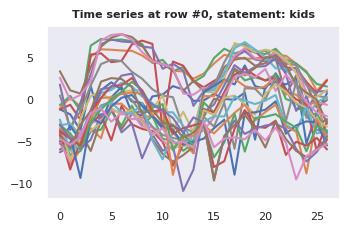

In [7]:
index = 0
statement = df['statement'][index]
plt.plot(traces[index])
plt.title(f'Time series at row #{index}, statement: {statement}')
plt.show()

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [9]:
# Normalization? No, decreases (somehow) accuracy
# old_shape = traces.shape[1:]
# X = MinMaxScaler().fit_transform(traces.reshape(-1, old_shape[0]*old_shape[1])).reshape((-1,)+old_shape)
X = traces

# Sets tests to be over actor 19 (excluded)
X_test = X[df.actor_number > 19]
y_test = df[TARGET][df.actor_number > 19].to_numpy()

# Sets the train and validation inside actors < 19
X_train, X_val, y_train, y_val = train_test_split(  X[df.actor_number <= 19], 
                                                    df[TARGET][df.actor_number <= 19].to_numpy(), 
                                                    test_size=0.2, random_state=100)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((1545, 27, 27), (387, 27, 27), (520, 27, 27), (1545,), (387,), (520,))

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


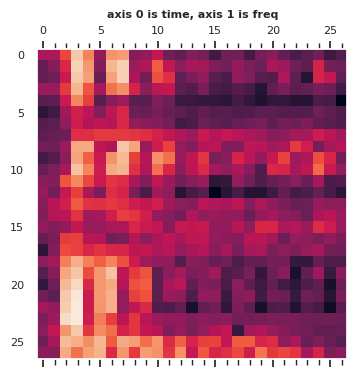

In [10]:
plt.matshow(X_test[0]);plt.grid(ls="")
plt.title("axis 0 is time, axis 1 is freq");

# CNN for statement and syllables 0&2

In [11]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

print(y_train[0])

y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

print(y_train[0])

dogs
0


In [12]:
import optuna
from keras.layers import BatchNormalization, Activation
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Dropout, GlobalAveragePooling1D, Flatten
from sklearn.metrics import accuracy_score

def build_model(input_shape, n_categories,
                n_conv=0, n_hidden=0, hidden_nodes=32,
                dropout=0.01, filters=8, kernel_size=5, **kwargs):
    
    # Stuff must be given in (timestep, spectral_coeff) format
    n_timesteps = input_shape[0]
    n_features = input_shape[1]

    model = Sequential()

    model.add(Conv1D(filters=filters,
                     kernel_size=kernel_size,
                     activation='relu',
                     input_shape=(n_timesteps, n_features),
                     name="base_conv"
                     ))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    for i in range(n_conv):
        model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
        model.add(BatchNormalization())
        model.add(Activation('relu'))

        model.add(Dropout(dropout))

#     model.add(GlobalAveragePooling1D())
    model.add(Flatten())
    for i in range(n_hidden):
        model.add(Dense(hidden_nodes, activation='relu'))

    model.add(Dense(n_categories, activation='softmax'))    
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

2023-07-12 13:03:23.617982: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-12 13:03:24.056489: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-12 13:03:24.058227: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-12 13:03:26.119947: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [13]:
# objective function to be minimized
def objective_fun(trial, X, y, validation_X, validation_y):

    n_conv = trial.suggest_int('n_conv', 0, 3)
    n_hidden = trial.suggest_int('n_hidden', 0, 3)
    hidden_nodes = trial.suggest_int('hidden_nodes', 8, 256)
    dropout = trial.suggest_float('dropout', 0, 0.4)
    filters = trial.suggest_int('filters', 2, 16)
    kernel_size = trial.suggest_int('kernel_size', 2, 16)
    batch_size = trial.suggest_int('batch_size', 16, 64)
    epochs = trial.suggest_int('epochs', 5, 90)
    
    print(f"Running little bitch having n_conv={n_conv}, dropout={dropout}, hidden_nodes={hidden_nodes}")
    
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
                        n_hidden=n_hidden,
                        hidden_nodes=hidden_nodes,
                        n_conv=n_conv,
                        dropout=dropout,
                        filters=filters,
                        kernel_size=kernel_size,
                       )

    cnn.fit(X, y, batch_size=batch_size, epochs=epochs, verbose=False)
    
    y_pred = np.argmax(cnn.predict(validation_X), axis=1)

    error = accuracy_score(validation_y, y_pred)

    return error


#study = optuna.create_study(direction='maximize')
#trial_function = lambda trial: objective_fun(trial, X_train, y_train, X_val, y_val)
#study.optimize(trial_function, n_trials=150, n_jobs=-1, catch=ValueError)

In [14]:
#best_params = study.best_params
best_params = {'n_conv': 1,
               'n_hidden': 2,
               'hidden_nodes': 52,
               'dropout': 0.018010877668116265,
               'filters': 12,
               'kernel_size': 10,
               'batch_size': 62,
               'epochs': 82}
best_params

{'n_conv': 1,
 'n_hidden': 2,
 'hidden_nodes': 52,
 'dropout': 0.018010877668116265,
 'filters': 12,
 'kernel_size': 10,
 'batch_size': 62,
 'epochs': 82}

In [15]:
cnn = build_model((27,27), 2, **best_params)
cnn.summary()
history = cnn.fit( np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)),
            epochs=30,#best_params["epochs"], 
            batch_size=best_params["batch_size"])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base_conv (Conv1D)          (None, 18, 12)            3252      
                                                                 
 batch_normalization (BatchN  (None, 18, 12)           48        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 18, 12)            0         
                                                                 
 extra_conv_0 (Conv1D)       (None, 9, 12)             1452      
                                                                 
 batch_normalization_1 (Batc  (None, 9, 12)            48        
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 9, 12)             0

In [16]:
from sklearn.metrics import f1_score, classification_report, cohen_kappa_score

y_pred = np.argmax(cnn.predict(X_test), axis=1)

print(f'Cohen k {cohen_kappa_score(y_test, y_pred)}')
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

17/17 [==============================] - 0s 4ms/step
Cohen k 0.9461538461538461
Accuracy 0.9730769230769231
F1-score [0.97318008 0.97297297]
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       260
           1       0.98      0.97      0.97       260

    accuracy                           0.97       520
   macro avg       0.97      0.97      0.97       520
weighted avg       0.97      0.97      0.97       520



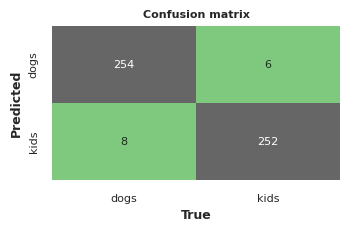

In [17]:
from sklearn.metrics import confusion_matrix

cf = confusion_matrix(y_test, y_pred)
sns.heatmap(cf, annot=True, cmap='Accent', fmt=".4g", cbar=False)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.xticks(ticks=[0.5, 1.5], labels=['dogs', 'kids'])
plt.yticks(ticks=[0.5, 1.5], labels=['dogs', 'kids'])
plt.title('Confusion matrix')
plt.savefig(os.path.join(IMAGE_FOLDER, 'ts_cnn_heatmap.pdf'), format='pdf')
plt.show()

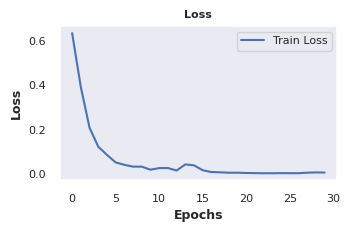

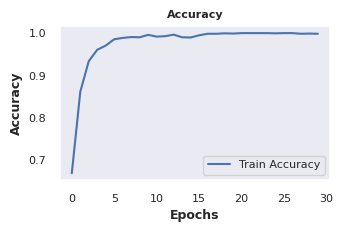

In [18]:
train_loss = history.history['loss']
#val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
#val_accuracy = history.history['val_accuracy']

plt.figure()
plt.plot(train_loss, label='Train Loss')
#plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(train_accuracy, label='Train Accuracy')
#plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

   # LIME Explainer 

### Define a new segmentation function

In [19]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [20]:
import skimage
from skimage.color import gray2rgb, rgb2gray

def make_prediction(color_img):
    gray_img = rgb2gray(color_img).reshape(-1,27,27)
    preds = cnn.predict(gray_img, verbose=False)
    return preds

In [21]:
from lime.wrappers.scikit_image import BaseWrapper


class RandomRectangleSegmentationAlgorithm(BaseWrapper):
    
    def __init__(self, **target_params):
        self.algo_type = "rand_rect"     
        BaseWrapper.__init__(self, 
                             RandomRectangleSegmentationAlgorithm.rand_rectangular_segmentation , 
                             **target_params)
        kwargs = self.filter_params(RandomRectangleSegmentationAlgorithm.rand_rectangular_segmentation)
        self.set_params(**kwargs)

    def __call__(self, *args):
        return self.target_fn(args[0], **self.target_params)
    
    @classmethod
    def rand_rectangular_segmentation(cls, image, dx=7, dy=7, random_offset=True):
        counter = 0
        mask = np.zeros(rgb2gray(image).shape)
        if random_offset:
            offset_x, offset_y = -np.random.randint(dx), -np.random.randint(dy)
        else:
            offset_x = 0
            offset_y = 0
        # N rectangles on x
        # M rectangles on y
        M, N = image.shape[0]//dy + 2, image.shape[1]//dx + 2
        
        for i in range(M):
            for j in range(N):
                mask[max(offset_y+i*dy, 0):min(offset_y + (i+1)*dy, image.shape[0]), max(offset_x + j*dx, 0):min(offset_x + (j+1)*dx, image.shape[0])] = counter
                counter += 1
        return mask.astype(int)

(27, 27)


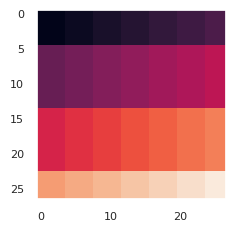

In [22]:
u = RandomRectangleSegmentationAlgorithm.rand_rectangular_segmentation(gray2rgb(X_test[0]), dx=4, dy=9, random_offset=True)
print(u.shape)
plt.imshow(u)

In [23]:
import skimage
from skimage.color import gray2rgb, rgb2gray

def make_prediction(color_img):
    gray_img = rgb2gray(color_img).reshape(-1,27,27)
    preds = cnn.predict(gray_img, verbose=False)
    return preds

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
(27, 27)


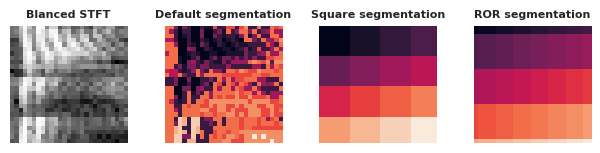

In [24]:
# Cerco di replicare il funzionamento delle funzioni di segmentazione di skimage
from skimage.segmentation import felzenszwalb,quickshift, checkerboard_level_set, chan_vese
idx = 2
fig, (axim, axdef, axsq, axrandrect) = plt.subplots(1,4,sharey=True, figsize=default_style.BAND_FULLSIZE_FIGURE)
axdef.axis("off")
axsq.axis("off")
axim.axis("off")
axrandrect.axis("off")

axim.imshow(X_test[idx], cmap="Greys_r", alpha=1)
axim.set_title("Blanced STFT")

seg = quickshift(gray2rgb(X_test[idx]), #Prende in input un RGB
                 kernel_size=4,
                 max_dist=10, 
                 ratio=0.2)

print(np.unique(seg)) # Escono numeri da 0 a qualcosa, sono le macchie che analizza
print(seg.shape) # Ha la shape della figura senza RGB

axdef.imshow(seg)
axdef.set_title("Default segmentation")


# Costruisco una funzione che:
# - prende come argomento una immagine RGB
# - fa dei quadrati numerati
def square_segmentation(image, square_size=7):
    counter = 0
    result = rgb2gray(image.copy())
    for i in range(image.shape[0]//square_size + 1):
        for j in range(image.shape[1]//square_size + 1):
            result[i*square_size:min((i+1)*square_size, image.shape[0]), j*square_size:min((j+1)*square_size, image.shape[0])] = counter
            counter+=1
    return result.astype(int)

seg = square_segmentation(gray2rgb(X_test[idx]))

axsq.imshow(seg)
axsq.set_title("Square segmentation")

seg = RandomRectangleSegmentationAlgorithm.rand_rectangular_segmentation(gray2rgb(X_test[idx]), dx=4, dy=8)
axrandrect.imshow(seg)
axrandrect.set_title("ROR segmentation")


fig.savefig("../images/stft_segmentation.pdf")

Use the default LIME wrapper for segmentation functions

## Positive pushing vs negative pushing features

  0%|                                                                                                                           | 0/3 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

 33%|██████████████████████████████████████▎                                                                            | 1/3 [00:06<00:12,  6.17s/it]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

 67%|████████████████████████████████████████████████████████████████████████████▋                                      | 2/3 [00:12<00:06,  6.45s/it]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:19<00:00,  6.48s/it]


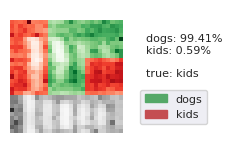

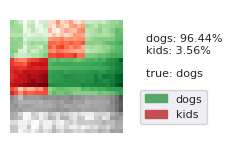

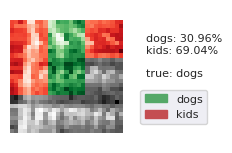

In [26]:
from matplotlib.patches import Patch
from tqdm import tqdm

explainer = lime_image.LimeImageExplainer()

dx, dy = 9,9
features_fraction = 0.8

figure_size = list(default_style.BAND_FULLSIZE_FIGURE)
figure_size[0] = figure_size[0]/3

for idx in tqdm([1, 50, 178]):

    legend_handles, legend_labels = [],[]
    fig, ax = plt.subplot_mosaic([["img", "leg"]], width_ratios=[1, 0.2], figsize=figure_size)
    ax["img"].imshow(X_test[idx], cmap="Greys_r")

    # Justifies the features that make him think both labels are true
    for pred in [0,1]:
        if pred == 0:#np.argmax(cnn.predict(X_test[idx].reshape(-1, 27, 27))):
            # Green if I study the features that agreee with the actual prediction
            color = "Greens_r"
            legend_color = "g"
        else:
            # Red for the features that makes him think otherwise
            color = "Reds_r"
            legend_color = "r"

        explanation = explainer.explain_instance(gray2rgb(X_test[idx]), 
                                                 classifier_fn=make_prediction, 
                                                 num_samples=300,
                                                 num_features=int(features_fraction*(27**2//(dx*dy))),
                                                 segmentation_fn=RandomRectangleSegmentationAlgorithm(dx=dx, dy=dy, random_offset=False),
                                                 hide_color=0.0,
                                                )

        temp, mask = explanation.get_image_and_mask(pred,
                                                    num_features=int(features_fraction*(27**2//(dx*dy))), 
                                                    hide_rest=True)
        zone = X_test[idx]*mask
        zone[zone == 0.0] = np.nan

        ax["img"].imshow(zone,cmap=color)

        legend_handles += [Patch(color=legend_color, label= f"{label_encoder.inverse_transform([pred])[0]}")]

    ax["leg"].legend(handles=legend_handles, 
                     loc="lower left", bbox_to_anchor=(0,0.1))
    ax["leg"].annotate( #f"true: {label_encoder.inverse_transform([y_test[idx]])[0]}\n"
                        #f"predicted: {label_encoder.inverse_transform([np.argmax(cnn.predict(X_test[idx].reshape(-1, 27, 27)))])[0]}\n"
                       #f"probabilities:"
                       f"dogs: {make_prediction(gray2rgb(X_test[idx]))[0,0]*100:4.2f}%\n"
                       f"kids: {make_prediction(gray2rgb(X_test[idx]))[0,1]*100:4.2f}%\n\n"
                        f"true: {label_encoder.inverse_transform([y_test[idx]])[0]}",
                      (0.5,0.5), ha="left")
    ax["leg"].set_xlim(0,1)
    ax["leg"].set_ylim(0,1)
    ax["img"].axis("off");
    ax["leg"].axis("off");
    plt.savefig(f"../images/explainability/test_{idx}_size_{dx}_{dy}.pdf")


## Average masks

Output()

already existing


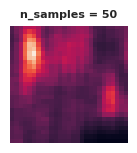

In [99]:
from matplotlib.patches import Patch
from rich.progress import track
features_fraction = 0.5


dx, dy = 3, 7
features_fraction = 0.8
n_samp = 50

kids_masks = []
dogs_masks = []

figure_4_size = list(default_style.BAND_FULLSIZE_FIGURE)
figure_4_size[0] = figure_4_size[0]/4

if os.path.exists(f"../dataset/explainability_masks/average_masks_dogs_size_{dx}_{dy}_len_50.npy"):
    print("already existing")


for idx in track(range(300)):
    
    explanation = explainer.explain_instance(gray2rgb(X_test[idx]), 
                                         classifier_fn=make_prediction, 
                                         num_samples=n_samp,
                                         num_features=int(features_fraction*(27**2//(dx*dy))),
                                         segmentation_fn=RandomRectangleSegmentationAlgorithm(dx=dx, dy=dy),
                                         hide_color=0.0,
                                        progress_bar=False
                                        )
    
    # Justifies the features that make him think both labels are true
    for pred in [0,1]:

        temp, mask = explanation.get_image_and_mask(pred,
                                                    num_features=int(features_fraction*(27**2//(dx*dy))), 
                                                    hide_rest=True)
        zone = X_test[idx]*mask
        zone[zone == 0.0] = np.nan
        if label_encoder.inverse_transform([pred]) == 'kids':
            kids_masks.append(mask)
        else:
            dogs_masks.append(mask)

np.save(f"../dataset/explainability_masks/average_masks_kids_size_{dx}_{dy}_len_50.npy", np.stack(kids_masks))
np.save(f"../dataset/explainability_masks/average_masks_dogs_size_{dx}_{dy}_len_50.npy", np.stack(dogs_masks))


fig, ax = plt.subplots(figsize=figure_4_size)
ax.axis("off")
ax.set_title(f"n_samples = {n_samp}")
cbar = ax.imshow(np.exp(np.mean(kids_masks, axis=0)/0.3))
# plt.colorbar(cbar)
fig.savefig(f"../images/mean_exp_{dx}_{dy}_nsamp_{n_samp}.pdf")

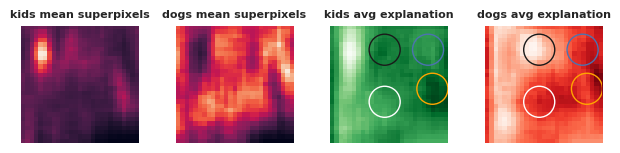

In [29]:
kids_masks = np.load(f"../dataset/explainability_masks/average_masks_kids_size_{dx}_{dy}_len_50.npy")
dogs_masks = np.load(f"../dataset/explainability_masks/average_masks_dogs_size_{dx}_{dy}_len_50.npy")

fig, (axkids, axdogs, axkids_exp, axdogs_exp) = plt.subplots(1, 4, figsize=default_style.BAND_FULLSIZE_FIGURE)
axkids.axis("off")
axdogs.axis("off")
axdogs_exp.axis("off")
axkids_exp.axis("off")

axkids.imshow(np.exp(np.mean(kids_masks, axis=0)/0.3))
axdogs.imshow(np.exp(np.mean(dogs_masks, axis=0)/0.3))

axkids.set_title('kids mean superpixels');
axdogs.set_title('dogs mean superpixels');

axkids_exp.set_title('kids avg explanation');
axdogs_exp.set_title('dogs avg explanation');

axkids_exp.imshow(np.mean(kids_masks*X_test[:300], axis=0)*(np.mean(kids_masks, axis=0)>0.0).astype(int), cmap="Greens_r")
axdogs_exp.imshow(np.mean(dogs_masks*X_test[:300], axis=0)*(np.mean(dogs_masks, axis=0)>0.0).astype(int), cmap="Reds_r")

axkids_exp.scatter([12], [5], s=500, facecolors='none', lw=1, edgecolors="k")
axdogs_exp.scatter([12], [5], s=500, facecolors='none', lw=1, edgecolors="k")

axkids_exp.scatter([22], [5], s=500, facecolors='none', lw=1, edgecolors="b")
axdogs_exp.scatter([22], [5], s=500, facecolors='none', lw=1, edgecolors="b")

axkids_exp.scatter([23], [14], s=500, facecolors='none', lw=1, edgecolors="orange")
axdogs_exp.scatter([23], [14], s=500, facecolors='none', lw=1, edgecolors="orange")

axkids_exp.scatter([12], [17], s=500, facecolors='none', lw=1, edgecolors="w")
axdogs_exp.scatter([12], [17], s=500, facecolors='none', lw=1, edgecolors="w")

plt.savefig(f"../images/explainability_mean_masks_{dx}_{dy}_nsamp_{n_samp}.pdf")

## Lasso and Ridge test

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       260
           1       0.94      0.98      0.96       260

    accuracy                           0.96       520
   macro avg       0.96      0.96      0.96       520
weighted avg       0.96      0.96      0.96       520



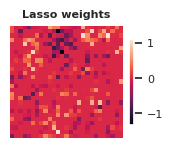

In [118]:
from sklearn.linear_model import Ridge, Lasso



regr = Lasso(alpha=0.008)
old_shape = X_train.shape[1:]
regr.fit(X_train.reshape(-1, X_train.shape[1]*X_train.shape[2]), y_train)

fig,ax = plt.subplots(figsize=figure_4_size)
ax.axis("off")

mappable = ax.imshow(regr.coef_.reshape(old_shape)*100)
cbar = plt.colorbar(mappable, shrink=0.7)
cbar.ax.minorticks_off()
ax.set_title("Lasso weights")
fig.savefig("../images/lasso_LIME.pdf")

y_pred = (regr.predict(X_test.reshape(-1, X_test.shape[1]*X_test.shape[2])) > 0.5 ).astype(int)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       260
           1       0.94      0.94      0.94       260

    accuracy                           0.94       520
   macro avg       0.94      0.94      0.94       520
weighted avg       0.94      0.94      0.94       520



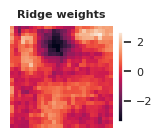

In [119]:
regr = Ridge(alpha=50_000)
old_shape = X_train.shape[1:]
regr.fit(X_train.reshape(-1, X_train.shape[1]*X_train.shape[2]), y_train)

fig,ax = plt.subplots(figsize=figure_4_size)
ax.axis("off")

mappable = ax.imshow(regr.coef_.reshape(old_shape)*1000)
cbar = plt.colorbar(mappable, shrink=0.7)
cbar.ax.minorticks_off()
ax.set_title("Ridge weights")
fig.savefig("../images/ridge_LIME.pdf")

y_pred = (regr.predict(X_test.reshape(-1, X_test.shape[1]*X_test.shape[2])) > 0.5 ).astype(int)
print(classification_report(y_test, y_pred))